# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 06

**Author 1 (282304):** Yuanyuan Zheng  
**Author 2 (328992):** Ju Wu   
**Author 3 (307251):** Shuo Wen   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [ ]:
import tarfile
import os

from google.colab import drive
drive.mount('/content/drive')

root_dir = "/content/drive/My Drive/"
# base_dir=root_dir+'lab-01-data'
base_dir = root_dir + 'IAPR/lab-01-data'
data_base_path = os.path.join(os.pardir, 'data')

tar_path = os.path.join(data_base_path, base_dir+ '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

Mounted at /content/drive


Other import:

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy.stats import mode

import skimage.io
import skimage.util
from skimage import morphology
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import threshold_mean, median
from skimage.morphology import closing, opening, white_tophat, disk

from sklearn.cluster import KMeans
from keras.preprocessing import image



---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmention as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

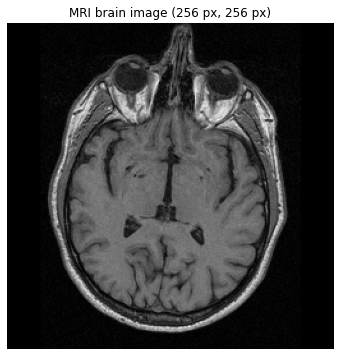

In [ ]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, 'lab-01-data')
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

In this section, I use the gray difference of neighboring pixels to implement region growing. The threshold is selected based on histogram distribution and the initial seed are chosen according to grayscale of brain region in need of detection.

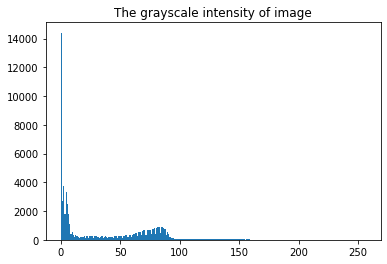

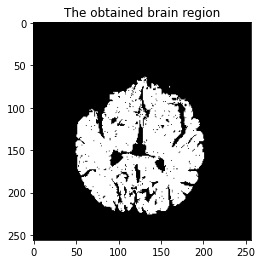

Number of pixels in brain region : 15032


In [ ]:
class Point(object):
 def __init__(self,x,y):
  self.x = x
  self.y = y

 def getX(self):
  return self.x
 def getY(self):
  return self.y

def getDiff(img,currentPoint,tmpPoint):
 return abs(int(img[currentPoint.x,currentPoint.y]) - int(img[tmpPoint.x,tmpPoint.y]))

def selectConnects(p):
 if p != 0:
  connects = [Point(-1, -1), Point(0, -1), Point(1, -1), Point(1, 0), Point(1, 1), \
     Point(0, 1), Point(-1, 1), Point(-1, 0)]
 else:
  connects = [ Point(0, -1), Point(1, 0),Point(0, 1), Point(-1, 0)]
 return connects

def regionGrow(img,seeds,thresh,p):
 height, weight = img.shape
 seedMark = np.zeros(img.shape)
 seedList = []
 label = 255
 for seed in seeds:
  seedList.append(seed)
  seedMark[seed.x,seed.y] = label
    
 connects = selectConnects(p)
 while(len(seedList)>0):
  currentPoint = seedList.pop(0)
  for cnc in connects:
   tmpX = currentPoint.x + cnc.x
   tmpY = currentPoint.y + cnc.y
   if tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= weight or seedMark[tmpX,tmpY]==label:
    continue
   Diff = getDiff(img,currentPoint,Point(tmpX,tmpY))
   if Diff < thresh and seedMark[tmpX,tmpY]==0:
    seedMark[tmpX,tmpY] = label
    seedList.append(Point(tmpX,tmpY))
 return seedMark
img=brain_im
#initial seeds
seeds = [Point(110,130),Point(175,160),Point(75,160)]
binaryImg = regionGrow(brain_im,seeds,4.5,1)
plt.title('The grayscale intensity of image')
plt.hist(img.ravel(),256,[0,256]); plt.show()
unique, counts = np.unique(binaryImg, return_counts=True)
plt.title('The obtained brain region')
plt.imshow(binaryImg, cmap='gray');plt.show()
print("Number of pixels in brain region :",counts[1])

### Discussion

Through the experiment of separating the brain region from the rest of the image, we can correctly separate the regions that share the same local grayscale intensity we define, and thus obtain good segmentation results. And at the same time, the motivation of the method is very simple and only need a small number of seed points to represent the property we want, then grow the region. For further improvement, extra criteria local patch variance can be introduced as well.
theoretical very efficient due to visiting each pixel by a limited bound of times.

However, we can also observe that this local method has no global view of the problem and sensitive to noise and initial selection of seeds. If the threshold keeps constant during the procedure, it is of possibility that a continuous path of points related to color may exist, which connects any two points in the image. In this task, a mark list is used to dynamically pop reference pixels and append newly marked pixels, and this kind of practically random memory access may slow down the algorithm, so adaption might be needed in the future modifications.

### 1.3 Contour detection (5pts)

In this section I convolve image with the second derivatives of LoG and find out the zero-crossing points to implement the edge detection.

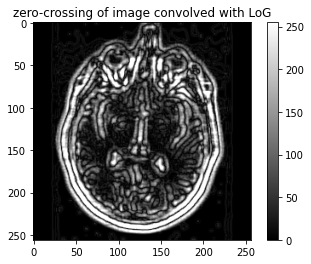

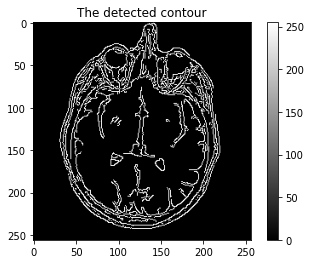

Number of pixels in brain region : 15121


In [ ]:
import cv2 as cv
ddepth = cv.CV_16S
src = cv.GaussianBlur(brain_im, (9, 9), 3)
dst = cv.Laplacian(src, ddepth, ksize=5)
abs_dst = cv.convertScaleAbs(dst)
plt.title('zero-crossing of image convolved with LoG')
plt.imshow(abs_dst, cmap='gray')
plt.colorbar()
plt.show() 
plt.title('The detected contour')
ini=(abs_dst<5).sum()
for i in range(abs_dst.shape[0]):
    for j in range(abs_dst.shape[1]):
        if abs_dst[i,j]<30:
         abs_dst[i,j]=0
unique, counts = np.unique(abs_dst, return_counts=True)
elem=dict(zip(unique, counts))
after=elem.get(0)
abs2=cv2.Canny(brain_im,80,240)
plt.imshow(abs2, cmap='gray')
plt.colorbar()
plt.show() 
print("Number of pixels in brain region :",after-ini)

### Discussion

The kernel size and sigma of the GaussianBlur have huge influence on the result of edge detection, appropriate selection of them can integrate local similarity and distinguish features of neighboring patches at the same time. We use built-in Canny contour detector as well to make comparison with LoG edge detector, and we can observe that Canny detector has better performance partially thanks to filer and hysteresis employed to remove noise, and non-maximum suppression applied to remove pixels that are not considered to be part of an edge.

### 1.4 Additional method (5pts)

Besides the region growing method and the edge detection method, there are still many other methods that are commonly used for image segmentation. To choose the adaptive one for our case, we need to observe carefully the image.

There are around 3 different degrees of gray intensity and 4 different structural parts in the image, let's enumerate these parts in fonction of their gray intensity:

- background, interconnection brain-skull (black)
- eye, nose, bones inside of the brain (black)
- brain (brain + brain folds) and a part of skull bone (gray)
- rest of skull (bright gray)

Our objective is to isolate the brain part. This part has not only the brain but also the brain folds, which should be counted into the brain part. The brain folds part has a gray intensity which is slightly darker than the brain part, but compares to the other parts, they are still close. We would like to unify the brain and the brain folds together. So a clustering-based segmentation should be useful to achieve it. Then we choose K-means with k = 4.

Once the result of K-means clustering is obtained, we can see that the brain region has a homogenous gray intensity and their intensity is different from the surrounding anatomic structure (result see figure "image after KMeans (k=4)").

Now we'd like to eliminate all the other pixels which don't have the same gray intensity as brain. We select a reference pixel that belongs to the brain part [150,150], the result after this cleaning is shown with figure "Image of pixels which have the same color as brain". From this image, we can see that the brain is well isolated. however, there are still some unwanted pixels on the skull part. Unlike the brain part where the pixels are connected continuously, the unwanted pixels are more dispersed. To remove them, we use a function in the skimage library called "skimage.measure.label", this function can label connected regions of an integer array. The result is shown in figure "connected components of image". The pixels in the same colors have the same labels. This time, the brain pixels are well separated from the outliers.

In the end, we keep only all the pixels that have the same label as our reference brain pixel [150,150], the final result of this operation is shown in figure "result". The total number of pixels belonging to the brain part is 15376. A detailed code and some comments can be found below.
In conclusion, we use the cascade method with Kmeans and region growing to isolate the brain region. This method can be used when the different objects in the image have a different color/intensity. The choice of the number of clusters k should be tunned, and a good choice of reference pixel is necessary. 






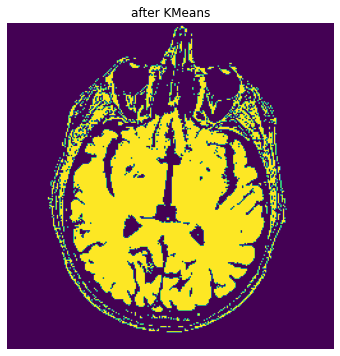

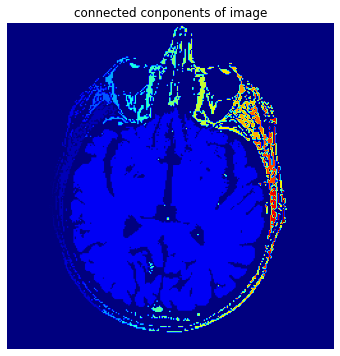

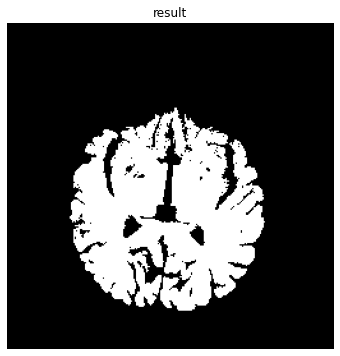

15206


In [ ]:
# KMean clustering allows to separate the different density

from sklearn.cluster import KMeans
from skimage.measure import label
import numpy as np



image_clustering = brain_im.copy()

# reshape the picture in order to compute kmeans
image_clustering_squeeze = image_clustering.reshape(image_clustering.shape[0]*image_clustering.shape[1],-1) 


# we chose 4 clusters for avoiding the loss/gain of brain region
kmeans = KMeans(n_clusters=4, random_state=0).fit(image_clustering_squeeze)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

# reshape the array for display the image
cluster_pic = pic2show.reshape(image_clustering.shape[0], image_clustering.shape[1],-1)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(cluster_pic[:,:,0], cmap='gray')
ax.set_title("image after KMeans (k=4)")
ax.axis('off')


# then we can identify a pixel which belongs to the brain, for exemple cluster_pic[150,150]
pic_final = cluster_pic==cluster_pic[150,150]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(pic_final[:,:,0], cmap='gray')
ax.set_title("Image of pixels which have the same color as brain")
ax.axis('off')

#plt.imshow(pic_final[:,:,0])

# We observe that the brain region is well kept and the pixels are continuous. then the region growing can be used 
# in order to filter out the other parts, we use the library skimage.measure, which 
# can compute the connected pixels and label them 

labels, nb_composant = label(pic_final, return_num=True, connectivity=1)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(labels[:,:,0], cmap='jet')
ax.set_title("connected conponents of image")
ax.axis('off')
plt.show()

# Since the labels[150,150] belongs to the brain, and all the pixels belongs to the brain 
# has the same labels, then we can filter out the pixels which have different labels than labels[150,150]
labels[labels!=labels[150,150]]=0
labels[labels==labels[150,150]]=1

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(labels[:,:,0], cmap='gray')
ax.set_title("result")
ax.axis('off')
plt.show()

# At the end, we can determine the how many pixels represent the brain :
print("total number of brain pixels: ",np.sum(labels))


### Discussion

In conclusion, we use the a cascade method with Kmeans and region growing to isolate the brain region. This method can be used when the different objects in the image have a different color/intensity. The choice of number of clusters k should be tunned, and a good choice of reference pixel is necessary. 


---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [ ]:
import skimage.io
import matplotlib.pyplot as plt

# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
data_path = os.path.join(data_base_path, 'lab-01-data')
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


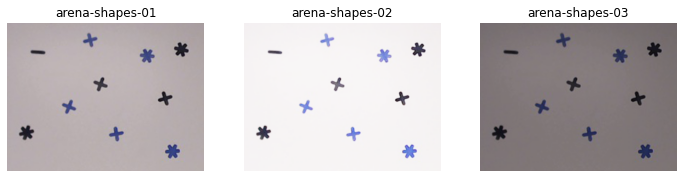

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In this task, we do the following steps:
1. Intensity normalization. Since the 3 images are under different illuminations, we apply normalization on brightness.
2. Get masks (foreground) by using adaptive threshold.
3. Remove noise from the mask. (The noise is easier to be found after adaptive threshold is applied, so we remove the noise at this step instead of before getting the mask.)
4. Using K-means to assign each pixel a label (background, blue, or black).
5. Traverse all the shapes (connected components) and decide which color (blue or black) the shape is. Then calculate the number of shapes and pixels of each color .

#### Intensity normalization

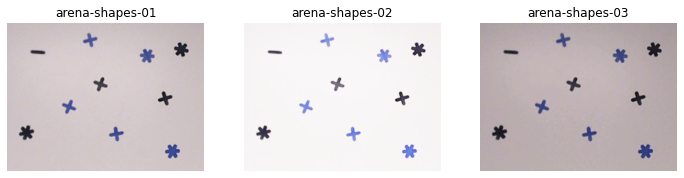

In [ ]:
# function of intensity normalization
def intensity_normalization(img):
    
    # convert image from RGB to HSV
    img_hsv = rgb2hsv(img)

    # normalize channel v (brightness channel)
    img_hsv[:,:,2] = (img_hsv[:,:,2] - img_hsv[:,:,2].min())/(img_hsv[:,:,2].max()-img_hsv[:,:,2].min())

    # convert image back to RGB
    img_rgb = hsv2rgb(img_hsv)
    img_rgb[img_rgb > 1] = 1
    img_rgb[img_rgb < 0] = 0

    return np.float32(img_rgb)

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
img_normed = []
for ax, img, name  in zip(axes.ravel(), images, im_names):
    img_norm = intensity_normalization(img)
    img_normed.append(img_norm)
    ax.imshow(img_norm)
    ax.axis('off')
    ax.set_title(name)
plt.show()

From the result we can see that since the shapes are in dark colors (blue and black), the effect of brightness normalization is more obvious under a darker background.

#### Adaptive Threshold

Using adaptive threshold to get the masks.

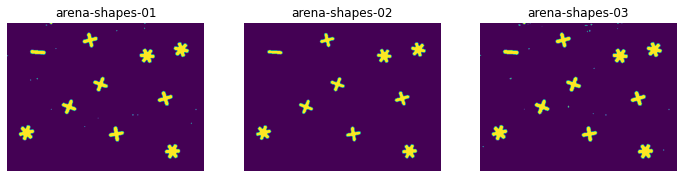

In [ ]:
masks = []
for img in img_normed:
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # convert image to grey-level
    img_grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # apply adaptive threshold and get the mask
    mask = 1-cv2.adaptiveThreshold(img_grey,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,99,4)
    masks.append(mask)

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, img, name in zip(axes.ravel(), masks, im_names):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(name)
plt.show()

#### Denoising

From the result of the masks we find that there is salt noise. So in this step, we first use median filter to remove the noise.

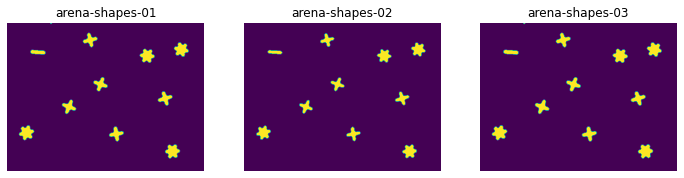

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
masks_denoise_medianfilter = []
for ax, img, name in zip(axes.ravel(), masks, im_names):

    # apply median filter
    img = ndimage.median_filter(img,size = 9)
    
    masks_denoise_medianfilter.append(img)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(name)
plt.show()

From the result we can see that, since the area of a single noise point is large, here we should use the median filter with size of 9 to remove the noise. However, the median filter of this size blurs the concave parts, for example, the inner right angle of the cross. 

So then we try opening (morphology) to remove the noise.

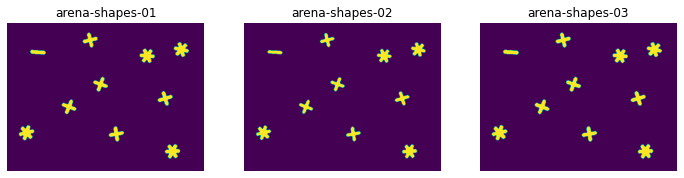

In [ ]:
# set the kernel of opening to cross with size 5
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
masks_denoise_opening = []

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, img, name in zip(axes.ravel(), masks, im_names):

    # apply opening on image
    img = ndimage.binary_opening(img, kernel, iterations=1) 
    
    masks_denoise_opening.append(img)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(name)
plt.show()

We can see that since the shapes are much larger than the noise points, opening works very well.

#### K-means

In this step we use K-means with K=3 (background, black, and blue). Then based on the pixel lables get from K-means and masks, we can traverse all the shapes and count the number of shapes and pixels for each color (black and blue).

arena-shapes-01 :
Black: Number of Shape: 5 , Total area: 5344
Blue: Number of Shape: 5 , Total area: 5697
arena-shapes-02 :
Black: Number of Shape: 5 , Total area: 4734
Blue: Number of Shape: 5 , Total area: 5058
arena-shapes-03 :
Black: Number of Shape: 5 , Total area: 5462
Blue: Number of Shape: 5 , Total area: 5824


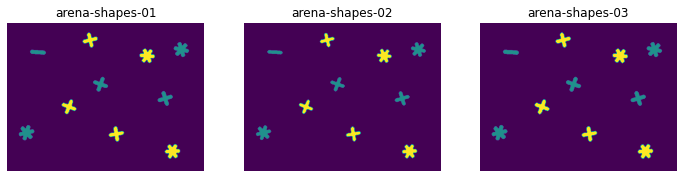

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, img, nm, mask in zip(axes.ravel(), images, im_names, masks_denoise_opening):

    # apply K-means and reshape the result
    kmeans = KMeans(n_clusters=3,random_state=3).fit_predict(img.reshape(-1, 3))
    label_kmeans = kmeans.reshape(mask.shape[:2])

    # label the connected part by using mask
    labeled_array, num_features = ndimage.label(mask, structure =np.ones((3,3)))

    # traverse the shapes and count the result
    counter = np.zeros(3)
    img = labeled_array.copy()

    # traverse the shapes
    for i in range(num_features):

        # kmeans_label shows which color this shape is
        kmeans_label, _ = mode(label_kmeans[labeled_array==i+1])

        # change the label in img, 1 for black and 2 for blue
        img[labeled_array == i+1] = kmeans_label

        # count the number of shapes of each color
        counter[kmeans_label] += 1

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(nm)

    # Here we divede the result of total area of blue shape by 2. 
    # Because the blue pixel lable is 2, the sum of the pixel label is 2 times the number of pixels
    # Since the black pixel lable is 1, the sum of the pixel label is exactly the number of pixels
    print(nm,":")
    print("Black: Number of Shape:", int(counter[1]), ", Total area:", img[img==1].sum())
    print("Blue: Number of Shape:" , int(counter[2]), ", Total area:", int(img[img==2].sum()/2))  
    
plt.show() 

### 2.3 Total area (in pixels) of each color (5 pts)

The result of total area has already been obtained when traversed the shapes. And the result are summarized in the following table.

|                          | arena-shapes-01 black  | arena-shapes-01 blue | arena-shapes-02 black | arena-shapes-02 blue  | arena-shapes-03 black | arena-shapes-03 blue |
|------------------------------------------|-----------|---------|----------|----------|----------|---------|
| Number of shapes | 5      |    5     | 5    |    5   |  5      | 5       |
| Total area (in pixels)     | 5344      | 5697     | 4734    |5058      | 5462     | 5864    |

#### Discussion

1. From the result we can see that the total area of arena-shapes-02 is smaller than the other two images. This is because in a very bright background, the edges of the shapes are blurred (especially the light blue part), and because the image contains both black and white, brightness normalization almost does not work, and finally causes some small mistakes at the edges.

2. For denoising, we find that median filter blur some special parts of the image. For example, even if the concave part is background (e.g. the inner right angle of the cross), the pixels around it are foreground. So as a result, concave part becomes foreground after we apply median filter on the image.